In [59]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np

def get_binance_ohlc(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v1/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])

        })
    df = pd.DataFrame(ohlc)
    # df.set_index('timestamp', inplace=True)
    return df



In [94]:
from datetime import datetime, timedelta

def generate_date_list(start_date_str, end_date_str, interval_days=4):
    # Convert string inputs to datetime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    # Generate list of dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    
    return date_list

In [114]:
def get_binance_ohlc_time(symbol, interval, start_str, end_str):
    print(start_str,"->",end_str)
    url = f'https://api.binance.com/api/v3/klines'
    
    # Convert start and end times to milliseconds since epoch
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts
    }
    response = requests.get(url, params=params)
    data = response.json()
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])
        })
    
    df = pd.DataFrame(ohlc)
    df.reset_index(drop=True, inplace=True)

    # df.set_index('timestamp', inplace=True)
    return df

In [215]:
def rule(df_btc, df, tp=1, sl=5, money=1000):
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []
    df['fluct'] = (df['close'] - df['open']) / df['open'] * 100
    df['amp'] = (df['high'] - df['low']) / df['low'] * 100

    df_btc['fluct'] = (df_btc['close'] - df_btc['open']) / df_btc['open'] * 100
    df_btc['amp'] = (df_btc['high'] - df_btc['low']) / df_btc['low'] * 100

    index_condition = []
    for i in range(2, len(df_btc)-1):
        # if df['fluct'].iloc[i] < -1 and df['fluct'].iloc[i-1]>0:
        #     index_condition.append(i+1)
        if df_btc['fluct'].iloc[i] > 0 and  df_btc['fluct'].iloc[i-1] > 0 and df_btc['fluct'].iloc[i-2] > 0 and df_btc['fluct'].iloc[i] < df_btc['fluct'].iloc[i-1] and df_btc['volumn'].iloc[i] > df_btc['volumn'].iloc[i-1]:
            index_condition.append(i+1)
        elif df_btc['fluct'].iloc[i] < 0 and  df_btc['fluct'].iloc[i-1] < 0 and df_btc['fluct'].iloc[i-2] < 0 and df_btc['volumn'].iloc[i] < df_btc['volumn'].iloc[i-1] and  df_btc['volumn'].iloc[i] < df_btc['volumn'].iloc[i-2]:
            index_condition.append(i+1)
    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        for j in range(i, len(df)):
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a 
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
            if high_check:
                # print("high", df_btc['volumn'].iloc[i-1]/df_btc['volumn'].iloc[i-2])
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i]) 
                # print("low", j-i)
                results.append((df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check:
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_high/number_low", round(number_high/(number_low+0.1), 3), "cannot_break", cannot_break)
    # print("number_lose:",number_high)
    # print("num win:", number_low)
    return money  *   (number_low * tp/100 + number_high * -sl/100),cannot_break, results, index_condition, number_high, number_low, list_reward, prices_list


In [206]:
start = "2023-06-12"
end = "2024-08-03"
list_day = generate_date_list(start, end, 5)
df_all = []
symb = "ORDIUSDT"
interval = "15m"
# for i in range(len(list_day)-1):
#     df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
#     df_all.append(df)
# df_all = pd.concat(df_all,ignore_index=True, axis=0)
# df_all.to_csv(f"{symb}_{start}_{end}_{interval}.csv", index=False)
df_all = pd.read_csv(f"{symb}_{start}_{end}_{interval}.csv")

In [194]:
df_all[df_all['timestamp']=="2024-05-01 00:00:00"]

,timestamp,open,high,low,close,volumn
1844,2024-05-01 00:00:00,373.8,374.9,371.6,372.4,663.4187


In [216]:
df = df_all.reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1)) 
display(df.tail(2))  
reward, cb, rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=1, sl=5)
reward

,timestamp,open,high,low,close,volumn
0,2023-11-07 19:00:00,5.905,11.8,5.905,10.0,1840312.07


,timestamp,open,high,low,close,volumn
25555,2024-07-30 23:45:00,38.11,38.11,37.79,37.84,7257.55
25556,2024-07-31 00:00:00,37.85,38.06,37.36,37.57,23452.44


check lai
check lai
num points:  1306 number_high/number_low 0.192 cannot_break 1


449.9999999999993

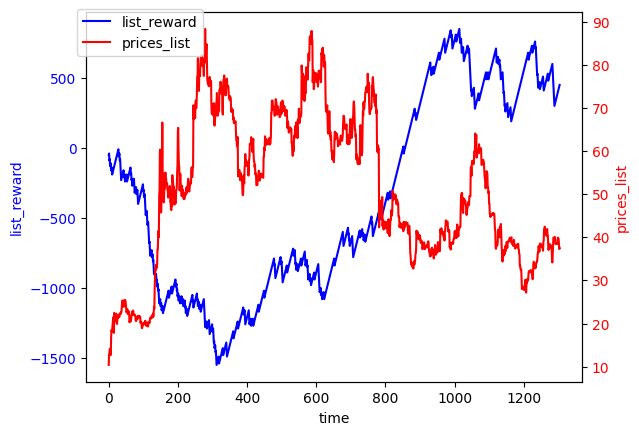

In [217]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()


In [2]:
import time
from datetime import datetime
from binance.spot import Spot
from binance_ft.um_futures import UMFutures
from helper import get_commision, get_precision, get_status_pos, key, secret, xlsx_to_nested_dict
from datetime import datetime, timedelta

# Initialize the Binance client
api_key="7NvUEUX4tnzOja5KQ99gmUG37DQOV9oelvz1akWAr2Zts9X57djRMwbvfgjQoykp"
api_secret="X9CWCXNsdypjEU8Q0AQaoaqPrcnaX4wpDe5KVxsAfThkVJJAvufiGJ3tb95QqnQC"
# client = UMFutures(key="c21f1bb909318f36de0f915077deadac8322ad7df00c93606970441674c1b39b", secret="be2d7e74239b2e959b3446b880451cbb4dee2e6be9d391c4c55ae7ca0976f403", base_url="https://testnet.binancefuture.com")
client = UMFutures(key=api_key, secret=api_secret)
def get_latest_kline_start_time(symbol, interval):
    klines = client.klines(symbol=symbol, interval=interval, limit=3)
    kline_start_time = int(klines[-1][0])
    return datetime.fromtimestamp(kline_start_time / 1000), klines

    

# Example usage
symbol = 'ORDIUSDT'
interval = '15m'
usdt = 1000
precision_ft = get_precision(symbol, client)
while True:
    kline_start_time, klines = get_latest_kline_start_time(symbol, interval)
    print(kline_start_time)
    next_kline_start_time = kline_start_time + timedelta(minutes=15)
    
    now = datetime.now()
    sleep_duration = (next_kline_start_time - now).total_seconds()    
    if sleep_duration > 0:
        print(f"Sleeping for {sleep_duration} seconds until the next kline starts...")
        time.sleep(sleep_duration)
        current_kline_time, klines = get_latest_kline_start_time(symbol, interval)
        ohlc = []
        for item in klines:
            ohlc.append({
                'timestamp': datetime.fromtimestamp(item[0] / 1000),
                'open': float(item[1]),
                'high': float(item[2]),
                'low': float(item[3]),
                'close': float(item[4])
            })
        df = pd.DataFrame(ohlc)
        df['fluct'] = (df['close'] - df['open']) / df['open'] * 100
        if current_kline_time>kline_start_time:
            print("A new kline has started!")
        else:
            print("In current kline")
            if df['fluct'].iloc[-1] < -0.8 and df['fluct'].iloc[-2] >0:
                order_price = df.iloc[-1]['close']
                high = order_price * 1.05
                low = order_price * 0.99
                print(current_kline_time, order_price, high, low)
                quantity_ft = round((usdt)/order_price, precision_ft)
                print("open")
                # close_future = client.new_order(symbol=symbol, side="SELL", type="MARKET", quantity=quantity_ft)
                while True:
                    askPrice = float(client.book_ticker(symbol)['askPrice'])
                    print("waiting_close...")
                    if askPrice > high or askPrice < low:

                        print(time.strftime("%Y-%m-%d %H:%M:%S"),"close", askPrice, high, low)
                        # close_future = client.new_order(symbol=symbol, side="BUY", type="MARKET", quantity=quantity_ft)
                        break
                    time.sleep(1)
            else:
                display(df)
    else:
        time.sleep(2)


2024-07-31 23:15:00
Sleeping for 431.366068 seconds until the next kline starts...


KeyboardInterrupt: 